# GANs (Generative Adversarial Networks)


Exemple de gan avec pytorch


[REQUIREMENTS.txt](#requirements)

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.io import imread

In [2]:
# --- Torchvision charger les données

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root='../tmp',
    train=True,
    transform=transform,
    download=True
)


In [3]:
print('Shape du jeu d''entrainement:', train_dataset.data.shape)
print('Target du jeu d''entrainement: ', train_dataset.targets)

Shape du jeu dentrainement: torch.Size([60000, 28, 28])
Target du jeu dentrainement:  tensor([5, 0, 4,  ..., 5, 6, 8])


In [4]:
# --- Data Loader
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size, shuffle=True)

In [5]:
# --- Discriminateur
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
)

In [6]:
# --- Générateur
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [7]:
# --- GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

D = D.to(device)
G = G.to(device)

cuda:0


In [8]:
# --- Fonction pour remettre les images à l'échelle [0, 1]
def scale_img(img):
    out = (img + 1) / 2
    return out

In [9]:
chemin_sortie = '../tmp/gan_images'
Path(chemin_sortie).mkdir(parents=True, exist_ok=True)

In [10]:
# --- Entraîner le modèle

criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# targets
ones = torch.ones(batch_size, 1).to(device)
zeros = torch.zeros(batch_size, 1).to(device)

d_losses = []
g_losses = []

for epoch in range(50):
    for inputs, _ in data_loader:
        
        n = inputs.size(0)
        inputs = inputs.reshape(n, 784).to(device)
        _ones = ones[:n]
        _zeros = zeros[:n]

        # Entraînement du discriminateur
        real_outputs = D(inputs)
        d_loss_real = criterion(real_outputs, _ones)

        noise = torch.randn(n, latent_dim).to(device)
        fake_images = G(noise)
        fake_outputs = D(fake_images)
        d_loss_fake = criterion(fake_outputs, _zeros)

        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()


        # Entraînement du générateur
        for _ in range(2):

            noise = torch.randn(n, latent_dim).to(device)
            fake_images = G(noise)
            fake_outputs = D(fake_images)

            g_loss = criterion(fake_outputs, _ones)
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
    
    print(f'Epoch: {epoch+1}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

    # Sauvegarder les images générées
    fake_images = fake_images.reshape(-1, 1, 28, 28)
    save_image(scale_img(fake_images), f'{chemin_sortie}/{epoch+1}.png')


Epoch: 1, d_loss: 0.6967481374740601, g_loss: 0.6971725225448608
Epoch: 2, d_loss: 0.6722572445869446, g_loss: 0.6697461009025574
Epoch: 3, d_loss: 0.6512671709060669, g_loss: 0.7213587760925293
Epoch: 4, d_loss: 0.676054835319519, g_loss: 0.7281202077865601
Epoch: 5, d_loss: 0.6867707967758179, g_loss: 0.7726415395736694
Epoch: 6, d_loss: 0.6961919069290161, g_loss: 0.7156429290771484
Epoch: 7, d_loss: 0.6766128540039062, g_loss: 0.7328288555145264
Epoch: 8, d_loss: 0.6774612069129944, g_loss: 0.7961874008178711
Epoch: 9, d_loss: 0.6869993209838867, g_loss: 0.7124203443527222
Epoch: 10, d_loss: 0.6735363006591797, g_loss: 0.7025693655014038
Epoch: 11, d_loss: 0.6949570178985596, g_loss: 0.7572924494743347
Epoch: 12, d_loss: 0.7014873027801514, g_loss: 0.7197643518447876
Epoch: 13, d_loss: 0.698664665222168, g_loss: 0.7166344523429871
Epoch: 14, d_loss: 0.6936585307121277, g_loss: 0.7122530937194824
Epoch: 15, d_loss: 0.6838515996932983, g_loss: 0.7399374842643738
Epoch: 16, d_loss: 0.

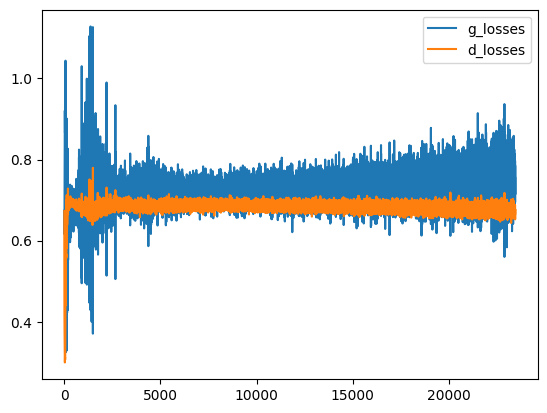

In [11]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()
plt.show()

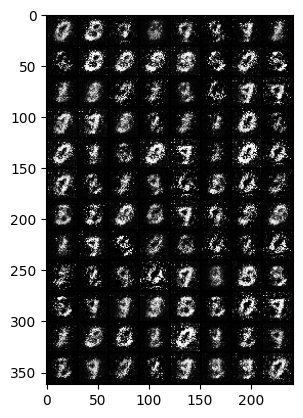

In [14]:
# check images générées à chaque epoch

# epoch 1
a = imread(f'{chemin_sortie}/1.png')
plt.imshow(a)

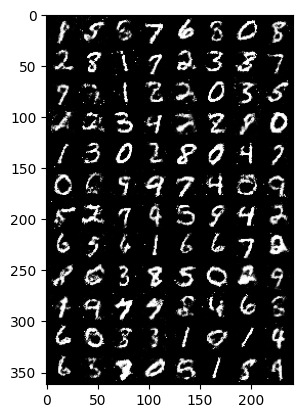

In [15]:
# epoch 20
a = imread(f'{chemin_sortie}/20.png')
plt.imshow(a)

## <a id="requirements" style="color:black">REQUIREMENTS.txt</a>

<span style="color:orange">Ce notebook a été créé avec python 3.10</span>

Requirements.txt  

```
alembic==1.13.2
aniso8601==9.0.1
anyio==4.4.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.15.0
bcrypt==4.1.3
beautifulsoup4==4.12.3      
bleach==6.1.0
blinker==1.8.2
boto3==1.35.35
botocore==1.35.40
cachetools==5.4.0
certifi==2024.6.2
cffi==1.16.0
charset-normalizer==3.3.2   
click==8.1.7
cloudpickle==3.0.0
colorama==0.4.6
comm==0.2.2
contourpy==1.2.1
cryptography==42.0.8        
cycler==0.12.1
databricks-sdk==0.31.1      
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
Deprecated==1.2.14
docker==7.1.0
entrypoints==0.4
exceptiongroup==1.2.1
executing==2.0.1
fastjsonschema==2.19.1
filelock==3.13.1
Flask==3.0.3
fonttools==4.53.0
fqdn==1.5.1
fsspec==2024.2.0
gitdb==4.0.11
GitPython==3.1.43
google-auth==2.34.0
graphene==3.3
graphql-core==3.2.3
graphql-relay==3.2.0
greenlet==3.0.3
h11==0.14.0
httpcore==1.0.5
httpx==0.27.0
idna==3.7
imageio==2.35.1
importlib_metadata==7.1.0
intel-openmp==2021.4.0
ipykernel==6.29.4
ipython==8.25.0
ipywidgets==8.1.3
isoduration==20.11.0
itsdangerous==2.2.0
jedi==0.19.1
Jinja2==3.1.3
jmespath==1.0.1
joblib==1.4.2
json5==0.9.25
jsonpointer==3.0.0
jsonschema==4.22.0
jsonschema-specifications==2023.12.1
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.10.0
jupyter-lsp==2.2.5
jupyter_client==8.6.2
jupyter_core==5.7.2
jupyter_server==2.14.1
jupyter_server_terminals==0.5.3
jupyterlab==4.2.2
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.2
jupyterlab_widgets==3.0.11
kiwisolver==1.4.5
lazy_loader==0.4
Mako==1.3.5
Markdown==3.6
MarkupSafe==2.1.5
matplotlib==3.9.0
matplotlib-inline==0.1.7
mistune==3.0.2
mkl==2021.4.0
mlflow==2.15.1
mlflow-skinny==2.15.1
mpmath==1.3.0
nbclient==0.10.0
nbconvert==7.16.4
nbformat==5.10.4
nest-asyncio==1.6.0
networkx==3.2.1
notebook==7.2.1
notebook_shim==0.2.4
numpy==1.26.3
opentelemetry-api==1.25.0
opentelemetry-sdk==1.25.0
opentelemetry-semantic-conventions==0.46b0
overrides==7.7.0
packaging==24.1
pandas==2.2.2
pandocfilters==1.5.1
paramiko==3.4.0
parso==0.8.4
pillow==10.2.0
platformdirs==4.2.2
prometheus_client==0.20.0
prompt_toolkit==3.0.47
protobuf==5.28.2
psutil==5.9.8
pure-eval==0.2.2
pyarrow==15.0.2
pyasn1==0.6.0
pyasn1_modules==0.4.0
pycparser==2.22
Pygments==2.18.0
PyNaCl==1.5.0
pyparsing==3.1.2
pysftp==0.2.8
python-dateutil==2.9.0.post0
python-json-logger==2.0.7
pytz==2024.1
pywin32==306
pywinpty==2.0.13
PyYAML==6.0.1
pyzmq==26.0.3
qtconsole==5.5.2
QtPy==2.4.1
querystring-parser==1.2.4
referencing==0.35.1
requests==2.32.3
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rpds-py==0.18.1
rsa==4.9
s3transfer==0.10.3
scikit-image==0.24.0
scikit-learn==1.5.1
scipy==1.14.0
Send2Trash==1.8.3
six==1.16.0
smmap==5.0.1
sniffio==1.3.1
soupsieve==2.5
SQLAlchemy==2.0.31
sqlparse==0.5.1
stack-data==0.6.3
sympy==1.12
tbb==2021.11.0
terminado==0.18.1
threadpoolctl==3.5.0
tifffile==2024.9.20
tinycss2==1.3.0
tomli==2.0.1
torch==2.3.1+cu121
torchaudio==2.3.1+cu121
torchvision==0.18.1+cu121
tornado==6.4.1
traitlets==5.14.3
types-python-dateutil==2.9.0.20240316
typing_extensions==4.9.0
tzdata==2024.1
uri-template==1.3.0
urllib3==2.2.1
waitress==3.0.0
wcwidth==0.2.13
webcolors==24.6.0
webencodings==0.5.1
websocket-client==1.8.0
Werkzeug==3.0.3
widgetsnbextension==4.0.11
wrapt==1.16.0
zipp==3.19.2
```